# deep-learning-project

Detecting Malaria cells using ResNets, Regularization and Data Augamentation in PyTorch

In [ ]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Detecting Malaria Cells using Deep Learning and PyTorch

The parasite Plasmodium causes the potentially fatal infectious disease malaria, which is spread to people via the bite of infected female Anopheles mosquitoes. Tropical and subtropical areas are affected by the disease, which poses a serious threat to world health, especially in sub-Saharan Africa, Southeast Asia, and parts of South America.

There are recurrent cycles of fever, chills, and flu-like symptoms brought on by the malaria parasite, which multiplies in the liver and infects red blood cells. Malaria primarily affects young children, pregnant women, and people with compromised immune systems. In extreme cases, it can result in anaemia, organ failure, and even death.

Insecticide-treated bed nets, indoor residual spraying, and antimalarial medications for both prevention and therapy are all used in the fight against malaria. Malaria control tactics have become more challenging as drug-resistant strains and insecticide-resistant insects have emerged.



In the fight against malaria, research, diagnosis, and early detection are essential elements. Modern developments in medical imaging and deep learning offer new options for more effective and accurate malaria cell detection, diagnosis, and monitoring. Rapid diagnostic tests and microscopic analysis of blood samples remain crucial tools for detecting the disease.





Our deep learning project aims to develop an efficient and accurate system for malaria cell detection using the ResNet architecture, incorporating regularization techniques, and enhancing the dataset with data augmentation in the PyTorch framework.

We are going to do it in the following steps:
1. Pick a Dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Prepare the dataset for training
5. Move the dataset to the GPU
6. Define a neural networks
7. Train the model

Make predictions on sample images iterate on it with different networks & hyperparameters

### Download the dataset from https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria'

In [ ]:
import os
import shutil

if os.path.exists('./cell-images-for-detecting-malaria'):
  shutil.rmtree('./cell-images-for-detecting-malaria')

In [ ]:
od.download(dataset_url, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shivangi2531
Your Kaggle Key: ··········


100%|██████████| 675M/675M [00:16<00:00, 41.7MB/s]


### Import the dataset into PyTorch


In [ ]:
data_dir = './cell-images-for-detecting-malaria/cell_images'

In [ ]:
import os

In [ ]:
import shutil

shutil.rmtree(data_dir + '/cell_images')

In [ ]:
os.listdir(data_dir)

['Uninfected', 'Parasitized']

In [ ]:
os.listdir(data_dir)

['Uninfected', 'Parasitized']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' +cls)))

Uninfected : 13780
Parasitized : 13780


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

27558

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=142x148 at 0x7B2D1C0ADAB0>, 0)

In [ ]:
dataset.classes

['Parasitized', 'Uninfected']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

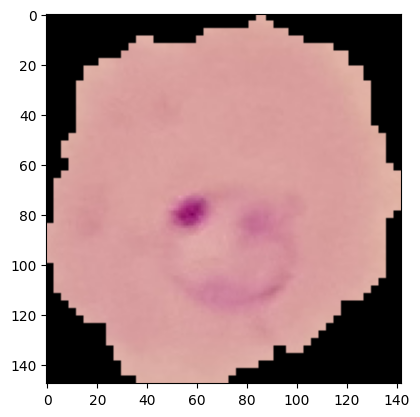

In [ ]:
img, label = dataset[0]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

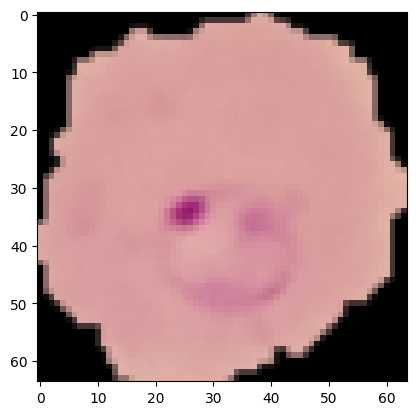

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(24803, 2755)

In [ ]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(24803, 2755)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

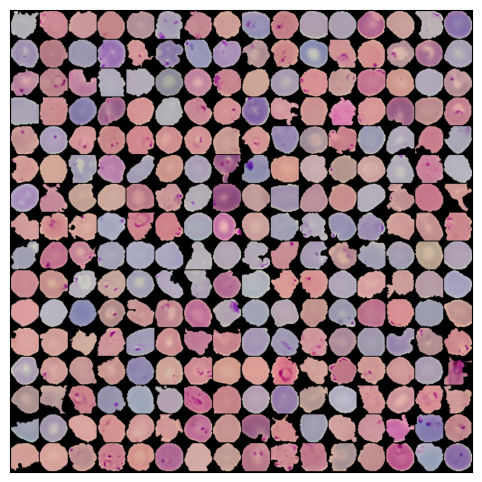

In [ ]:
show_batch(train_dl)


## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
img, label = dataset[0]
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Model and Training utilities

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)



This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

Go through the following blog posts to learn more:

* Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
* Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, label = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)

  break

images.shape torch.Size([256, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([256, 2])


### Training

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6929202675819397, 'val_acc': 0.5007666945457458}]

In [ ]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5839, val_loss: 0.1432, val_acc: 0.9481
Epoch [1], train_loss: 0.1713, val_loss: 0.1260, val_acc: 0.9558
Epoch [2], train_loss: 0.1552, val_loss: 0.1237, val_acc: 0.9549
Epoch [3], train_loss: 0.1547, val_loss: 0.1240, val_acc: 0.9581
Epoch [4], train_loss: 0.1371, val_loss: 0.1157, val_acc: 0.9586


In [ ]:
history += fit(5, 1e-5, model, train_dl, val_dl, torch.optim.SGD)

Epoch [0], train_loss: 0.1325, val_loss: 0.1094, val_acc: 0.9638
Epoch [1], train_loss: 0.1294, val_loss: 0.1166, val_acc: 0.9596
Epoch [2], train_loss: 0.1316, val_loss: 0.1176, val_acc: 0.9589
Epoch [3], train_loss: 0.1306, val_loss: 0.1119, val_acc: 0.9613
Epoch [4], train_loss: 0.1330, val_loss: 0.1093, val_acc: 0.9617


In [ ]:
history += fit(5, 1e-5, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1269, val_loss: 0.1074, val_acc: 0.9612
Epoch [1], train_loss: 0.1209, val_loss: 0.1029, val_acc: 0.9596
Epoch [2], train_loss: 0.1204, val_loss: 0.0990, val_acc: 0.9600
Epoch [3], train_loss: 0.1174, val_loss: 0.1008, val_acc: 0.9596
Epoch [4], train_loss: 0.1145, val_loss: 0.1037, val_acc: 0.9634


### Our model trained to 96.34% accuracy

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

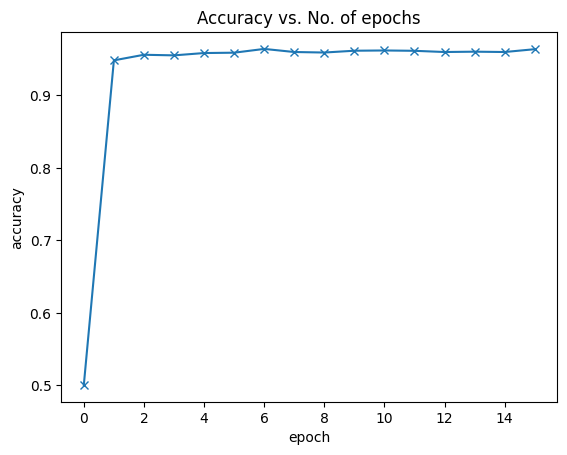

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

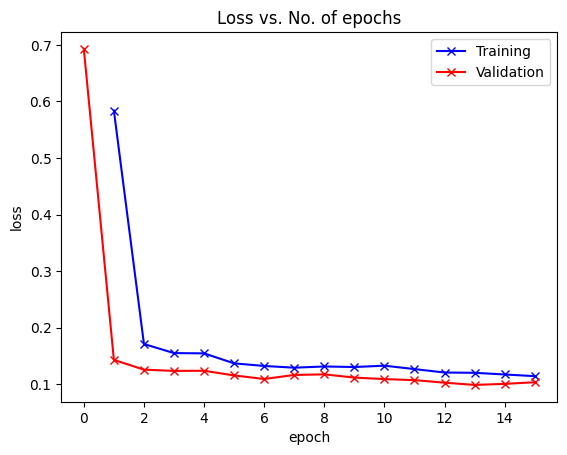

In [ ]:
plot_losses(history)

### Record Results

In [ ]:
history[-1]

{'val_loss': 0.10371407866477966,
 'val_acc': 0.9634451270103455,
 'train_loss': 0.1144738495349884}

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_dataset(image_size = 64)
jovian.log_hyperparams(batch_size = 256, arch='ResNet9', epochs = [5, 5, 5], lrs = [0.001, 1e-5, 1e-5], opt = ['Adam', 'SGD', 'Adam'])
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc'],
                   val_loss = history[-1]['val_loss'])

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [ ]:
jovian.commit(project='deep-learning-project-2')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit(project='deep-learning-project-2')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Test with Individuals Images


In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1, 2, 0)))
  pred = predict_image(img, model, dataset.classes)
  print('Target: ', dataset.classes[label])
  print('Prediction: ', pred)

Target:  Uninfected
Prediction:  Uninfected


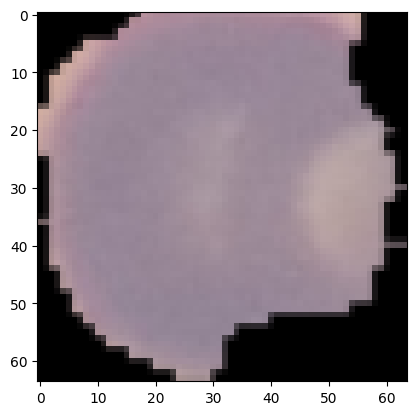

In [ ]:
show_image_prediction(*val_ds[100])

Target:  Uninfected
Prediction:  Uninfected


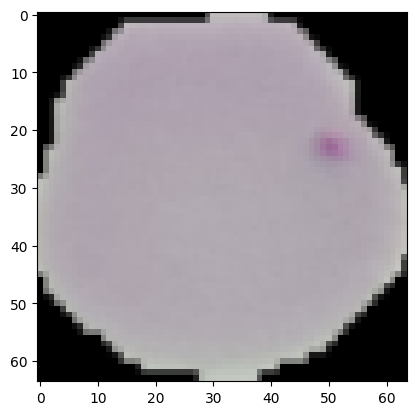

In [ ]:
show_image_prediction(*val_ds[0])

Target:  Parasitized
Prediction:  Parasitized


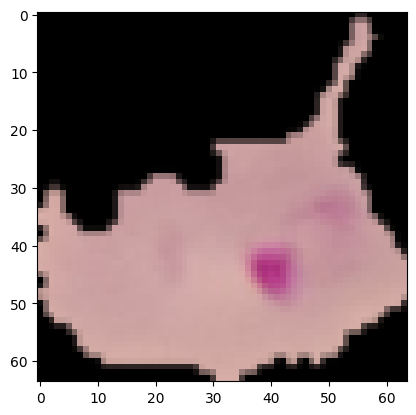

In [ ]:
show_image_prediction(*val_ds[45])

Target:  Uninfected
Prediction:  Uninfected


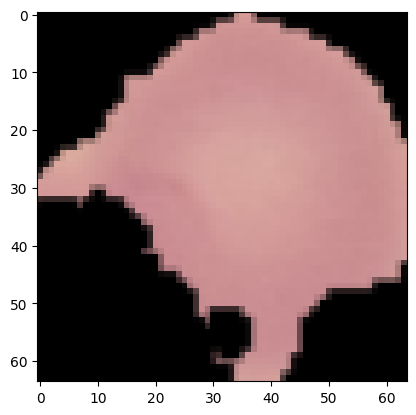

In [ ]:
show_image_prediction(*val_ds[1123])

Target:  Parasitized
Prediction:  Parasitized


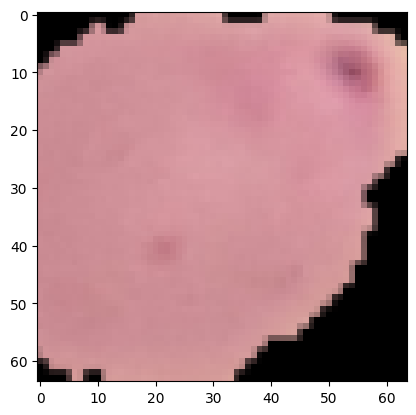

In [ ]:
show_image_prediction(*val_ds[2344])

In [ ]:
torch.save(model.state_dict(), 'malaria-cell-ResNet9.pth')

In [ ]:
jovian.commit(projects='deep-learning-project-2',
              output=['malaria-cell-ResNet9.pth'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
